In [163]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import Input
from tensorflow.keras.layers import (InputLayer, Dense, Flatten, GlobalMaxPooling1D, GlobalAveragePooling1D, 
                                     SimpleRNN, LSTM, 
                                     Bidirectional, Lambda, Embedding, Dropout, Conv1D, MaxPooling1D)
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tqdm.keras import TqdmCallback # progress bars
import re
import matplotlib.pyplot as plt
import seaborn as sns



In [164]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# concatenate the dataframes 
df = pd.concat([df_train, df_test], keys=['train', 'test'])
df.text = df.text.astype("string")


## Data Cleaning & Manipulation

In [165]:
vocab_size = 30000
sequence_length = 30

In [166]:
# should just be letters numbers and spaces 
# https://stackoverflow.com/questions/68991917/
# regex-to-not-allow-special-characters-failing-in-python
# need to clean the text to create a standard training set
def convertText(text_tensor):
    nonalpha_string = '[^a-zA-Z0-9\s]'
    http_string = "http\S*"
    apostrophe_string = "'"
    space_string = "\s\s+"
    
    nonalpha_char = re.compile(nonalpha_string)
    http_char = re.compile(http_string)
    apostrophe_char = re.compile(apostrophe_string)
    space_char = re.compile(space_string)
    
    text_tensor = tf.strings.regex_replace(text_tensor, http_string, "")
    text_tensor = tf.strings.regex_replace(text_tensor, nonalpha_string, " ")
    text_tensor = tf.strings.regex_replace(text_tensor, apostrophe_string, "")
    text_tensor = tf.strings.regex_replace(text_tensor, space_string, " ")
    return tf.strings.strip(tf.strings.lower(text_tensor))

## EDA

In [167]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


The data set is split apart, we can see a preview of some of the text of the tweets

In [168]:
for i in np.arange(0,10,1):
    print(i, df_train.text[i])

0 Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1 Forest fire near La Ronge Sask. Canada
2 All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3 13,000 people receive #wildfires evacuation orders in California 
4 Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
5 #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
6 #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
7 I'm on top of the hill and I can see a fire in the woods...
8 There's an emergency evacuation happening now in the building across the street
9 I'm afraid that the tornado is coming to our area...


We have to manipulate the data further to standardize the characters in order to have a quality set for the model to learn

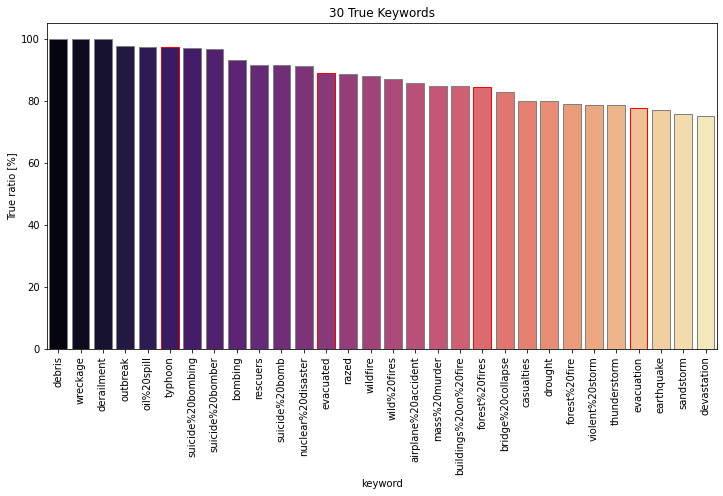

In [169]:
fig, ax = plt.subplots(figsize=(12,6))
true_ratios = df_train.groupby('keyword')['target'].mean()\
.sort_values(ascending=False).mul(100)
values = np.array([2,5,3,6,4,7,1])   
idx = np.array(list('abcdefg')) 
clrs = ['grey' if (x < max(values)) else 'red' for x in values ]

sns.barplot(x = true_ratios.index[:30], y = true_ratios.values[:30], ax = ax, 
            palette = 'magma', edgecolor = clrs)
plt.xticks(rotation=90)
plt.title("30 True Keywords")
plt.ylabel("True ratio [%]")
plt.show()

Debris is the most true idea that was tweeted out, while devestation was the least. Additionally, there are characters that need to be cleaned to get modeled. 

In [170]:
highest_prob = df_train.groupby('keyword').\
agg({'text':np.size, 'target':np.mean})\
.rename(columns={'text':'Count', 'target':'Probability of Disaster'})
highest_prob.sort_values('Probability of Disaster', 
                         ascending=False).head(20)

,Count,Probability of Disaster
keyword,,
debris,37,1.000000
wreckage,39,1.000000
derailment,39,1.000000
outbreak,40,0.975000
oil%20spill,38,0.973684
typhoon,38,0.973684
suicide%20bombing,33,0.969697
suicide%20bomber,31,0.967742
bombing,29,0.931034


The top words that most likely relate to a disaster and the probability attached to the side

In [171]:
lowest_prob = df_train.groupby('keyword').agg({'text':np.size, 
                                               'target':np.mean})\
.rename(columns={'text':'Count', 
                 'target':'Probability of Disaster'})
lowest_prob.sort_values('Probability of Disaster',  
                        ascending=True).head(20)

,Count,Probability of Disaster
keyword,,
aftershock,34,0.000000
body%20bags,41,0.024390
ruin,37,0.027027
blazing,34,0.029412
body%20bag,33,0.030303
electrocute,32,0.031250
screaming,36,0.055556
traumatised,35,0.057143
panicking,33,0.060606


In [172]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers
# /TextVectorization
# https://www.tensorflow.org/text/guide/word_embeddings
# https://towardsdatascience.com/you-should-
# try-the-new-tensorflows-textvectorization-layer-a80b3c6b00ee

vect = TextVectorization(max_tokens=vocab_size, standardize=convertText,
                output_sequence_length=sequence_length)
vect.adapt(df.text.to_numpy())
vocab = vect.get_vocabulary()

In [173]:
X_train = vect(df_train.text.to_numpy())
y = df_train.target.to_numpy()
X_test = vect(df_test.text.to_numpy())

train = tf.data.Dataset.from_tensor_slices((X_train, y))
test = tf.data.Dataset.from_tensor_slices((X_test))

In [174]:
# modify the size of our data so its more manageable
ds = train.shuffle(buffer_size=10000).cache().enumerate()
train = ds.filter(lambda i, data: i % 10 <= 7).\
map(lambda _, data: data).cache()
ds_dev = ds.filter(lambda i, data: i % 10 > 7).\
map(lambda _, data: data).cache()

In [175]:
BATCH_SIZE = 1024

train = train.batch(BATCH_SIZE)
ds_dev = ds_dev.batch(BATCH_SIZE)
test = test.batch(BATCH_SIZE)

In [176]:
# initial layer
embedding_dim = 64
embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                        input_length=sequence_length, mask_zero=True)


In [177]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy')
]

# Helper Plotting Functions

In [178]:
def plotMetrics(history):
    plt.plot(history['accuracy'], color = "blue", label = "accuracy")
    plt.plot(history['val_accuracy'], color = "red", label = "val_accuracy")
    plt.plot(history['loss'], color = "green", label = "loss")
    plt.legend(loc="center right")
    plt.title("Accuracy, Val_accuracy, and loss curves")
    plt.show()

## Model # 1

In [179]:
# original unstacked simpleRNN model
model_1 = Sequential([
    embedding_layer,
    SimpleRNN(64),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1),
])


model_1.summary()
model_1.compile(optimizer='Adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS,
             )
history = model_1.fit(train, epochs=100, validation_data=ds_dev, 
                    verbose=0).history

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 30, 64)            1920000   
                                                                 
 simple_rnn_31 (SimpleRNN)   (None, 64)                8256      
                                                                 
 dense_48 (Dense)            (None, 64)                4160      
                                                                 
 dropout_24 (Dropout)        (None, 64)                0         
                                                                 
 dense_49 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,932,481
Trainable params: 1,932,481
Non-trainable params: 0
_________________________________________________________________


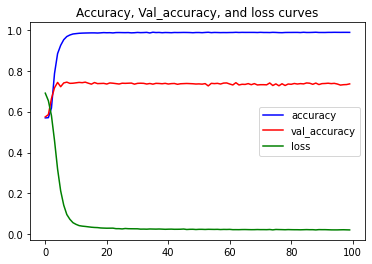

In [180]:
plotMetrics(history)

In [204]:
print("Accuracy value: ", history['accuracy'][-1]*100,"%")

Accuracy value:  98.80151152610779 %


Very interesting to see practically no loss value, as well as accuracy and the validation set accuracy to be drastically different. It seems like the model does not do well with the validation set (could be a sign of overfitting the current model). 

In [181]:
model_1.fit(train.concatenate(ds_dev), epochs=100, verbose=0)
predictions = model_1.predict(test)

In [182]:
predictions = (tf.sigmoid(model_1.predict(test)).numpy() > 0.5)\
.astype(int).reshape((-1,))
submission_model_1 = pd.DataFrame({
    'id': df_test.id.to_numpy(),
    'target': predictions,
})

In [183]:
submission_model_1.to_csv('submission_model_1.csv', index=False)

## Model #2

In [184]:
# added a recurrent layer on top of the original model

model_2 = Sequential([
    embedding_layer,
    SimpleRNN(64, return_sequences = True),
    SimpleRNN(64),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1),
])
model_2.summary()
model_2.compile(optimizer='Adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics = METRICS
             )
history2 = model_2.fit(train, epochs=100, validation_data=ds_dev, 
                       verbose=0).history


Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 30, 64)            1920000   
                                                                 
 simple_rnn_32 (SimpleRNN)   (None, 30, 64)            8256      
                                                                 
 simple_rnn_33 (SimpleRNN)   (None, 64)                8256      
                                                                 
 dense_50 (Dense)            (None, 64)                4160      
                                                                 
 dropout_25 (Dropout)        (None, 64)                0         
                                                                 
 dense_51 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,940,737
Trainable params: 1,940,737
N

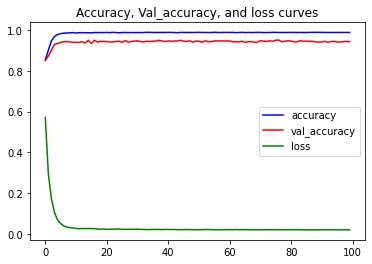

In [185]:
plotMetrics(history2)

In [205]:
print("Accuracy value: ", history2['accuracy'][-1]*100,"%")

Accuracy value:  98.78509044647217 %


Very interesting to note that the val accuracy is lower in this scenario, which means the model works in most cases outside the training set. The drastic distinction can be concerning as this model might not fare well The loss values down to zero over time.

In [186]:
model_2.fit(train.concatenate(ds_dev), epochs=100, verbose=0)
predictions = model_2.predict(test)

In [187]:
predictions = (tf.sigmoid(model_2.predict(test)).numpy() > 0.5)\
.astype(int).reshape((-1,))
submission_model_2 = pd.DataFrame({
    'id': df_test.id.to_numpy(),
    'target': predictions,
})

In [188]:
submission_model_2.to_csv('submission_model_2.csv', index=False)

## Model #3

In [189]:
# added another recurrent layer
model_3 = Sequential([
    embedding_layer,
    SimpleRNN(64, return_sequences = True),
    SimpleRNN(64, return_sequences = True),
    SimpleRNN(64),    
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1),
])
model_3.summary()
model_3.compile(optimizer='Adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics= METRICS
             )
history3 = model_3.fit(train, epochs=100, validation_data=ds_dev, 
                       verbose=0).history



Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 30, 64)            1920000   
                                                                 
 simple_rnn_34 (SimpleRNN)   (None, 30, 64)            8256      
                                                                 
 simple_rnn_35 (SimpleRNN)   (None, 30, 64)            8256      
                                                                 
 simple_rnn_36 (SimpleRNN)   (None, 64)                8256      
                                                                 
 dense_52 (Dense)            (None, 64)                4160      
                                                                 
 dropout_26 (Dropout)        (None, 64)                0         
                                                                 
 dense_53 (Dense)            (None, 1)               

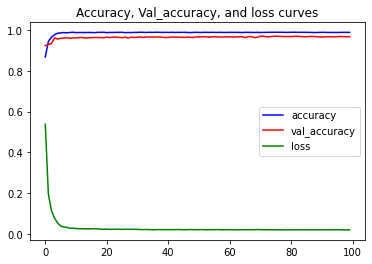

In [190]:
plotMetrics(history3)

In [206]:
print("Accuracy value: ", history3['accuracy'][-1]*100,"%")

Accuracy value:  98.76867532730103 %


The accuracy and the validation set accuracy are very close to one another. This is showing a more consistent and robust model in comparison to the other models

The accuracy value is also slowly falling, with Model 3 being the least 'accurate', however, the accuracy levels are very high still. 

In [191]:
model_3.fit(train.concatenate(ds_dev), epochs=100, verbose=0)
predictions = model_3.predict(test)

In [192]:
predictions = (tf.sigmoid(model_3.predict(test)).numpy() > 0.5)\
.astype(int).reshape((-1,))
submission_model_3 = pd.DataFrame({
    'id': df_test.id.to_numpy(),
    'target': predictions,
})

In [193]:
submission_model_3.to_csv('submission_model_3.csv', index=False)